<a href="https://colab.research.google.com/github/Mugambi645/ml-and-dl-notebooks/blob/main/Classifying_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Classifying movie reviews: A binary classification task</h2>

The IMDb dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

In [1]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000
)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [3]:
train_labels[0]

np.int64(1)

In [4]:
# No word exceeds 10,000
max([max(sequence) for sequence in train_data])

9999

For kicks, let’s quickly decode one of these reviews back to English words.

In [5]:
# word_index is a dictionary mapping words to an integer index.
word_index = imdb.get_word_index()
# Reverses it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Decodes the review. Note that the indices are offset by 3 because 0,
# 1, and 2 are reserved indices for "padding," "start of sequence," and
# "unknown."
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
decoded_review[:100]

"? this film was just brilliant casting location scenery story direction everyone's really suited the"

Note that the leading ? corresponds to a start token that has been prefixed to each review.

<h3>Data Preparation</h3>
Neural networks can’t directly process lists of integers because they vary in length. To use them as input, you must convert these lists into fixed-size tensors. There are two main methods:

Padding sequences
Make all lists the same length by padding them, then feed them into an embedding layer.

Multi-hot encoding
Convert each list into a large binary vector indicating which words appear in the sequence (e.g., [8, 5] becomes a vector with 1s at positions 5 and 8).

The text chooses the second method—multi-hot encoding—to manually vectorize the data.

In [7]:
import numpy as np
# Creates an all-zero matrix of shape (len(sequences), num_classes)
def multi_hot_encode(sequences, num_classes):
  results = np.zeros((len(sequences), num_classes))
  for i, sequence in enumerate(sequences):
   # Sets specific indices of results[i] to 1s
   results[i][sequence] = 1.0
  return results

# Vectorized training data
x_train = multi_hot_encode(train_data, num_classes=10000)
# Vectorized test data
x_test = multi_hot_encode(test_data, num_classes=10000)

In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
# Vectorize labels, converting from int to float
y_train = train_labels.astype("float32")
x_train = test_labels.astype("float32")

<h3>Building the Model</h3>
The model is trained using a simple neural network made of Dense layers: two hidden layers with 16 units (ReLU), and a final layer that outputs a single value for sentiment prediction.

In [10]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_shape=(10000,)),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Each Dense layer’s unit count sets the size of the learned representation. More units mean more learning capacity but higher risk of overfitting. Hidden layers use ReLU to keep only positive values, while the final layer uses sigmoid to output a probability between 0 and 1.

Activation functions introduce non-linearity, allowing neural networks to learn complex patterns. Without them, Dense layers would only perform linear transformations, and stacking more layers wouldn’t increase model power. ReLU is the most common non-linear activation, while sigmoid is used for probability outputs. For binary classification, the model uses binary_crossentropy as the loss and Adam as the optimizer.

In [11]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


<h3>Model Validation</h3>
You set aside part of the training data as a validation set to monitor model performance during training without using the test set. The test set must remain untouched so it can provide an unbiased final evaluation after all training decisions are made.

In [12]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [13]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We’ll now train the model for 20 epochs (20 iterations over all samples in the training data), in mini-batches of 512 samples. At the same time, we’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the validation_data argument to model.fit().

In [14]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.6691 - loss: 0.6367 - val_accuracy: 0.8566 - val_loss: 0.4203
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8886 - loss: 0.3488 - val_accuracy: 0.8854 - val_loss: 0.3004
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9336 - loss: 0.2175 - val_accuracy: 0.8881 - val_loss: 0.2760
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9542 - loss: 0.1570 - val_accuracy: 0.8849 - val_loss: 0.2813
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9692 - loss: 0.1140 - val_accuracy: 0.8834 - val_loss: 0.2953
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9824 - loss: 0.0823 - val_accuracy: 0.8807 - val_loss: 0.3165
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9876 - loss: 0.0617 - val_accuracy: 0.8786 - val_loss: 0.3424
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9930 - loss: 0.0456 - val_accuracy: 0.8777 - 

You can automatically create a validation set by using validation_split in model.fit(), which reserves a fraction of the training data (e.g., 20%) for validation. The training returns a History object that stores all metrics recorded during training.
```
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)
```

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

The History object stores the training and validation metrics (loss and accuracy). You can plot these values using Matplotlib to visualize how the model performed during training.

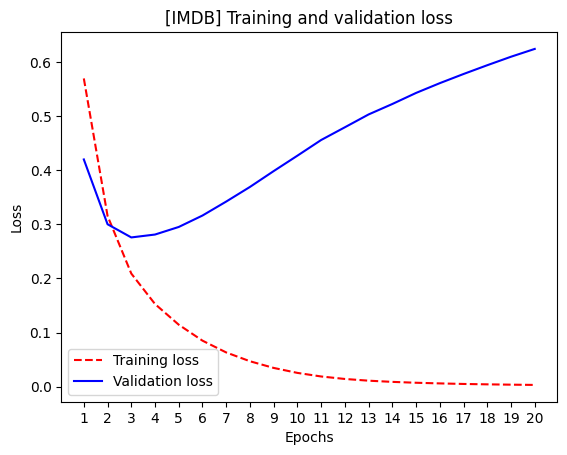

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
# "r--" is for "dashed red line."
plt.plot(epochs, loss_values, "r--", label="Training loss")
# "b" is for "solid blue line."
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("[IMDB] Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

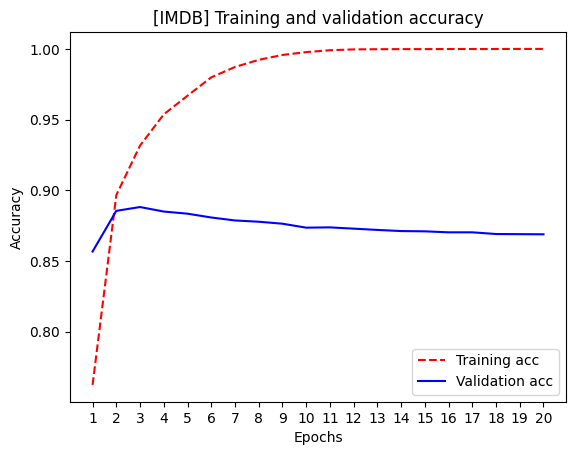

In [17]:
# Clears the figure
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("[IMDB] Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Training loss decreases and accuracy increases each epoch, but validation metrics peak early — a sign of overfitting. To prevent it, stop training once validation performance stops improving (here, after 4 epochs) before evaluating on test data.

In [19]:
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_shape=(10000,)),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, test_labels)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7137 - loss: 0.6048
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9036 - loss: 0.2769
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9370 - loss: 0.1879
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9533 - loss: 0.1431
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8791 - loss: 0.3062


In [20]:
results

[0.3057262599468231, 0.8805999755859375]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

<h3>Using a trained model to generate predictions on new data</h3>
After having trained a model, you’ll want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the predict method,

In [21]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.16243231],
       [0.9999186 ],
       [0.617407  ],
       ...,
       [0.08503126],
       [0.06214049],
       [0.6284676 ]], dtype=float32)

Further experiments
 The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:

- You used two representation layers before the final classification layer. - Try using one or three representation layers and see how doing so affects validation and test accuracy.
- Try using layers with more units or fewer units: 32 units, 64 units, and so on.
- Try using the mean_squared_error loss function instead of binary_crossentropy.
- Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.